# Caption generator retrieval accuracy
Here we will analyse the results obtained from the retrieval.py script in which we tested our caption generator's retrieval performance on the levels described in ../level_generator/PythonAPI/level_analysis.ipynb

In [44]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
#Loading results
with open('ic_performance_results.pkl', 'rb') as input:
    results = pickle.load(input)

The results dictionary are structured by number of images in the level (n), by number of common objects shared by those images (c), and then by a list of length 50 in which a successful retrieval is coded as a 1 whereas a failure is indicated by a 0.

In [2]:
print(results.keys())
print()
print(results[3].keys())
print()
print(len(results[3][4]))
print()
print(results[3][4][16])

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10])

dict_keys([1, 2, 3, 4, 5])

50

0


## Retrieving average accuracy

In [3]:
tot = 0
ones = 0
for n in results.keys():
    for c in results[n].keys():
        for r in results[n][c]:
            tot +=1
            if r == 1:
                ones +=1
print("Our system's average accuracy over all levels is: ", round(ones/tot, 3))

Our system's average accuracy over all levels is:  0.202


## Plotting all our results 
Red line = baseline of choosing an image at random.

In [4]:
accs = []
tots = []
for n in results.keys():
    temp_accs = []
    temp_tots = []
    for c in results[n].keys():
        temp_ones = np.sum(results[n][c])
        temp_tot = len(results[n][c])
        temp_accs.append(round(temp_ones/temp_tot, 4))
        temp_tots.append(temp_tot)   
    accs.append(temp_accs)
    tots.append(temp_tots)

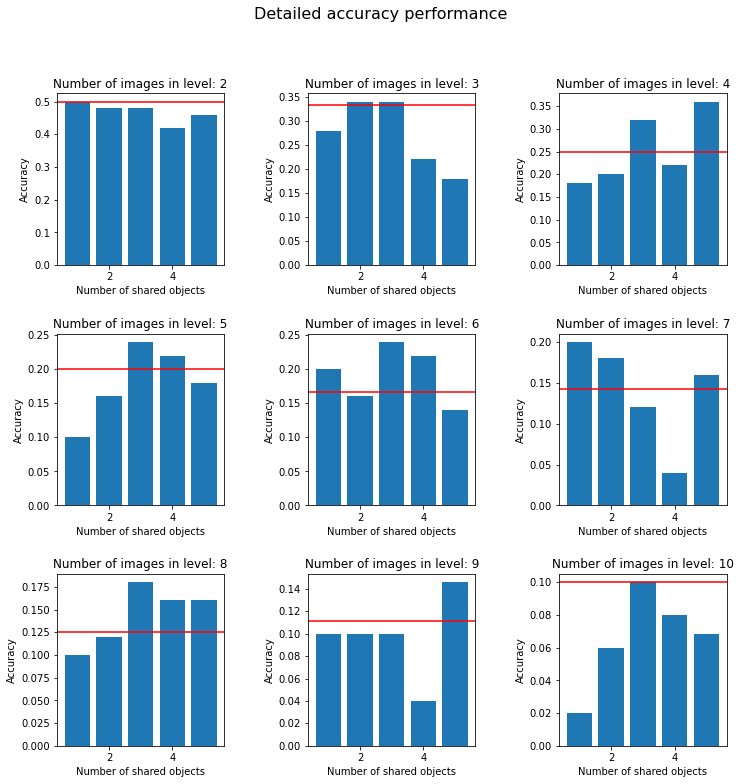

In [38]:
fig = plt.figure(figsize = (12, 12))
fig.suptitle('Detailed accuracy performance', fontsize=16)
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.bar(range(1, 6), accs[i])
    ax.axhline(1/(i+2), color='red')
    #plt.legend(bbox_to_anchor=(1.05, 1))
    #ax.xlabel('Test instance')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Number of shared objects')
    ax.title.set_text('Number of images in level: '+ str(i+2))
plt.subplots_adjust(wspace = 0.5, hspace = 0.4)
plt.savefig('CG_accuracy.jpg')
plt.show()


# Analysis
The first of our result analysis will consist of looking into how the image captioner performed on some randomly selected levels, since this was the first step in the retrieval task.

In [45]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import pickle
import matplotlib.pyplot as plt
import skimage.io as io
from pycocotools.coco import COCO
from utilities import get_dataset, get_examples
from pytorch_lightning.callbacks import ModelCheckpoint
from pl_model import CaptionGenerator, FlickrDataModule
from PIL import Image
from bleu import BLEU
import torchvision.transforms as transforms

In [48]:
#load levels
with open('../../data/levels.pkl', 'rb') as input:
    levels = pickle.load(input)
    
#loading training dataset and transform
transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
        ]
    )

dataset, pad_idx = get_dataset(
                            '../../data/flickr8k/images',
                            '../../data/flickr8k/training_captions.csv',
                            transform)
#load model
epoch_file = '../../data/caption_generator/version_24/checkpoints/epoch=998.ckpt'
model = CaptionGenerator.load_from_checkpoint(checkpoint_path = epoch_file, pad_idx = pad_idx)

In [105]:
#np.random.seed(167)
n = np.random.randint(2, 11)
c = np.random.randint(1, 6)
e = np.random.randint(0, 50)
sample = levels[n][c][e]

In [106]:
print('The selected example consists of', n, 'images with at least', c, 'common objects belonging to these categories: ', sample['selected_set'])

The selected example consists of 5 images with at least 1 common objects belonging to these categories:  ['train']


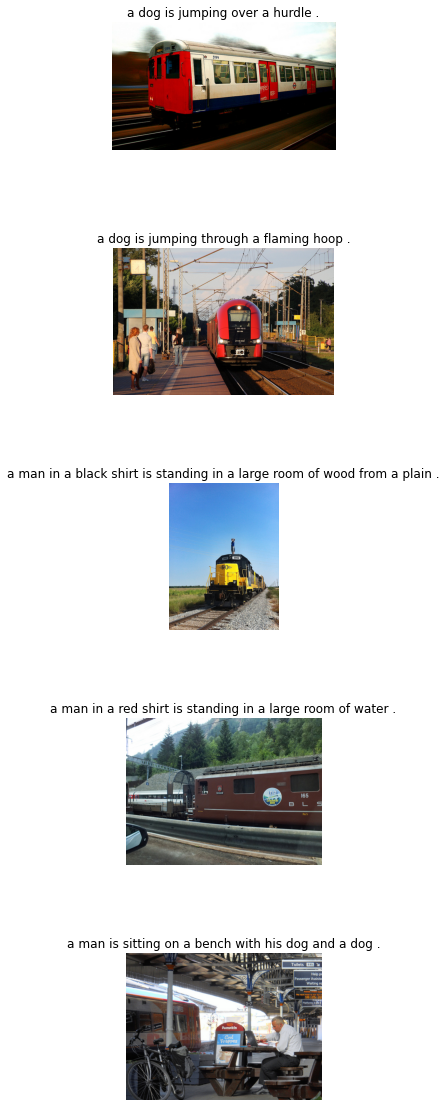

In [107]:
fig = plt.figure(figsize = (4, 20))
#fig.suptitle('Sampled images and their generated captions', fontsize=16)
for i in range(n):
    ax = fig.add_subplot(n, 1, i+1)
    im = io.imread(sample['imgs'][i]['coco_url'])
    im_mod = transform(Image.fromarray(im).convert('RGB')).unsqueeze(0)
    caption = ' '.join(model.caption_image(im_mod, dataset.vocab)[1:-1])
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(caption)
plt.subplots_adjust(wspace = 0.3, hspace = 0.6)
plt.savefig('IC_analysis.jpg')
plt.show()